In [224]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import math
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, ExtractHaarFeatures
from classifier import WeakClassifier, WeakClassifierError

plt.rcParams['figure.facecolor']='white'

In [208]:
# Hyper-parameters

# Number of randomized Haar-features
nbrHaarFeatures = 100

# Number of training images, will be evenly split between faces and
# non-faces. (Should be even.)
nbrTrainImages = 1000

# Number of weak classifiers
nbrWeakClassifiers = 50

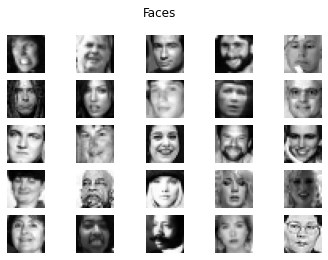

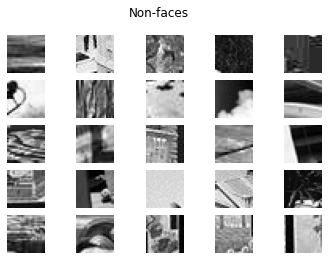

In [209]:
# Load face and non-face data and plot a few examples
faces = sio.loadmat('faces.mat')['faces']
nonfaces = sio.loadmat('nonfaces.mat')['nonfaces']

faces = faces.astype('double')[:,:,np.random.permutation(faces.shape[-1])]
nonfaces = nonfaces.astype('double')[:,:,np.random.permutation(nonfaces.shape[-1])]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()

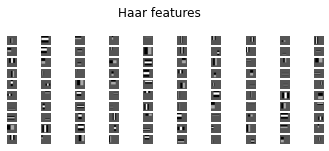

In [210]:
# Generate Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures)

plt.figure()
for k in range(nbrHaarFeatures):
    plt.subplot(20,10,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()

In [211]:
# Create image sets (do not modify!)

# Create a training data set with examples from both classes.
# Non-faces = class label y=-1, faces = class label y=1
trainImages = np.concatenate((faces[:,:,:nbrTrainImages//2], nonfaces[:,:,:nbrTrainImages//2]), axis=2)
xTrain = ExtractHaarFeatures(trainImages,haarFeatureMasks)
yTrain = np.concatenate((np.ones(nbrTrainImages//2), -np.ones(nbrTrainImages//2)))

# Create a test data set, using the rest of the faces and non-faces.
testImages  = np.concatenate((faces[:,:,nbrTrainImages//2:], nonfaces[:,:,nbrTrainImages//2:]), axis=2)
xTest = ExtractHaarFeatures(testImages,haarFeatureMasks)
yTest = np.concatenate((np.ones(faces.shape[2]-nbrTrainImages//2), -np.ones(nonfaces.shape[2]-nbrTrainImages//2)))

# Variable for the number of test-data.
nbrTestImages = yTest.shape

In [243]:
# Implement the AdaBoost training here
# Use your implementation of WeakClassifier and WeakClassifierError in classifier.py

def StrongClassifier(nbrHaarFeatures,nbrWeakClassifiers):
    d=np.ones(nbrTrainImages)/nbrTrainImages #initial d_t(i)=1/num_XTrain
    cutoff_list=np.zeros(nbrWeakClassifiers)
    p_list=np.zeros(nbrWeakClassifiers)
    alpha_list=np.zeros(nbrWeakClassifiers)
    h_index_list=np.zeros(nbrWeakClassifiers)
    # to save time, we compute the output of the decision tree on training data at every possible cutoff value for all weak classifiers and p,and save the data in a 4-dimension matrix
    #(HaarFeatures,p,cutoff value,x)
    indicator_func=np.zeros((nbrHaarFeatures,2,nbrTrainImages,nbrTrainImages))
    for nhaar in range(nbrHaarFeatures):
        for p in range(2):
            for t_index in range(nbrTrainImages):
                t=xTrain[nhaar,t_index]
                h=WeakClassifier(t, (1,-1)[p], xTrain[nhaar,])
                indicator_t=[1 if h[i]!=yTrain[i] else 0 for i in range(nbrTrainImages)]
                indicator_func[nhaar,p,t_index,]=indicator_t
        
    for niter in range(nbrWeakClassifiers): 
        error=np.array([[indicator_func[i,j,:,:]@d for j in range(2)] for i in range(nbrHaarFeatures)])
        error[error>0.5]=1-error[error>0.5]
        min_index=np.unravel_index(error.argmin(),error.shape,order="C") # index of parameters where error is minimized
        
        error_min=np.min(error) 
        index_min=min_index[0]
        p_min=(1,-1)[min_index[1]]
        t_min=xTrain[index_min,min_index[2]]
        h_min=WeakClassifier(t_min,p_min,xTrain[index_min,])
        alpha_min=0.5*math.log((1-error_min)/error_min)
        d=np.multiply(d,np.exp(-alpha_min*np.multiply(yTrain,h_min))) # updata d
        d=d/sum(d) #renormalize d
        
        cutoff_list[niter]=xTrain[min_index[0],min_index[2]]
        p_list[niter]=p_min
        alpha_list[niter]=alpha_min
        h_index_list[niter]=int(index_min)
    return cutoff_list, p_list, alpha_list, h_index_list

In [244]:
# Implement the AdaBoost training here
# Use your implementation of WeakClassifier and WeakClassifierError in classifier.py
'''
def minerror(x_data,y_data,d):
    n=len(x_data)
    error=np.array([WeakClassifierError(WeakClassifier(x_data[i], 1, x_data), [1]*n, y_data) for i in range(n)])
    p=[-1 if error[i]>0.5 else 1 for i in range(n)]
    error=np.array([WeakClassifierError(WeakClassifier(x_data[i], p[i], x_data), d, y_data) for i in range(n)])
    index_min=error.argmin()
    error_min=min(error)
    p_min=p[index_min]
    t_min=x_data[index_min]
    return error_min,t_min,p_min

def StrongClassifier(nbrHaarFeatures,nbrWeakClassifiers):
    d_t=np.ones(nbrTrainImages)/nbrTrainImages
    alpha_list=[]
    index_list=[]
    t_list=[]
    p_list=[]
    for n_weak in range(nbrWeakClassifiers):
        data=np.array([minerror(xTrain[n_classifiers,:],yTrain,d_t) for n_classifiers in range(nbrHaarFeatures)])
        error_list=data[:,0]
        t_data=data[:,1]
        p_data=data[:,2]
        h_index=error_list.argmin()
        t_t=t_data[h_index]
        p_t=p_data[h_index]
        h_t=WeakClassifier(t_t, p_t, xTrain[h_index,:])
        alpha_t=0.5*np.log((1-min(error_list))/min(error_list))
        d_t=[d_t[i]*np.exp(-alpha_t*yTrain[i]*h_t[i]) for i in range(nbrTrainImages)]
        d_t=[d/sum(d_t) for d in d_t]
        alpha_list.append(alpha_t)
        index_list.append(h_index)
        t_list.append(t_t)
        p_list.append(p_t)
    return alpha_list,index_list,t_list,p_list
'''

'\ndef minerror(x_data,y_data,d):\n    n=len(x_data)\n    error=np.array([WeakClassifierError(WeakClassifier(x_data[i], 1, x_data), [1]*n, y_data) for i in range(n)])\n    p=[-1 if error[i]>0.5 else 1 for i in range(n)]\n    error=np.array([WeakClassifierError(WeakClassifier(x_data[i], p[i], x_data), d, y_data) for i in range(n)])\n    index_min=error.argmin()\n    error_min=min(error)\n    p_min=p[index_min]\n    t_min=x_data[index_min]\n    return error_min,t_min,p_min\n\ndef StrongClassifier(nbrHaarFeatures,nbrWeakClassifiers):\n    d_t=np.ones(nbrTrainImages)/nbrTrainImages\n    alpha_list=[]\n    index_list=[]\n    t_list=[]\n    p_list=[]\n    for n_weak in range(nbrWeakClassifiers):\n        data=np.array([minerror(xTrain[n_classifiers,:],yTrain,d_t) for n_classifiers in range(nbrHaarFeatures)])\n        error_list=data[:,0]\n        t_data=data[:,1]\n        p_data=data[:,2]\n        h_index=error_list.argmin()\n        t_t=t_data[h_index]\n        p_t=p_data[h_index]\n        

In [245]:
# Evaluate your strong classifier here
# Evaluate on both the training data and test data, but only the test accuracy
# can be used as a performance metric since the training accuracy is biased.

In [246]:
cutoff_list, p_list, alpha_list,index=StrongClassifier(nbrHaarFeatures,nbrWeakClassifiers)
print(f"weak classifiers index:{index}")

weak classifiers index:[88. 88. 50. 50. 50. 50. 51. 20. 20. 24. 24. 49. 49. 89. 88. 88. 88. 88.
 32. 37. 37. 37. 32. 32. 41. 63. 90. 19. 19. 61. 61. 61. 61. 61. 61.  9.
  9.  9.  9. 13. 93.  7.  7.  7. 79. 79. 16. 99. 99. 88.]


In [247]:
def fit(cutoff,p,alpha,h_index,x):
    data=np.array([x[int(i),] for i in h_index])
    h_data=[WeakClassifier(cutoff[i],p[i],data[i,]) for i in range(len(p))]
    H_data=np.sign(sum(np.multiply(alpha.reshape(len(alpha),1),h_data)))
    return H_data

# Evaluate on the training data 
fit_train=fit(cutoff_list, p_list, alpha_list,index,xTrain)
# Evaluate on test data
fit_test=fit(cutoff_list, p_list, alpha_list,index,xTest)
# accuracy on train data
n_tr=len(yTrain)
actr=sum([1 if fit_train[i]==yTrain[i] else 0 for i in range(n_tr)])/n_tr
# accuracy on test data
n_te=len(yTest)
acte=sum([1 if fit_test[i]==yTest[i] else 0 for i in range(n_te)])/n_te
(actr,acte)

(0.956, 0.923057346454021)

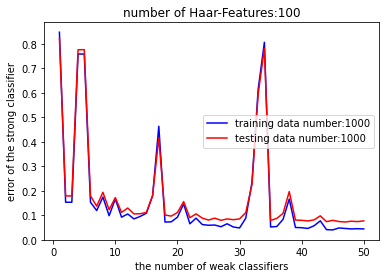

In [248]:
# Plot the error of the strong classifier as a function of the number of weak classifiers.
# Note: you can find this error without re-training with a different number of weak classifiers.

def StrongClassifierError(cutoff,p,alpha,h_index,X,Y):
    fit_data=fit(cutoff,p,alpha,h_index,X)
    n_data=len(Y)
    error=sum([1 if fit_data[i]!=Y[i] else 0 for i in range(n_data)])/n_data
    return error

# calculate in training data
error_list_train=[StrongClassifierError(cutoff_list[0:i],p_list[0:i],alpha_list[0:i],index[0:i],xTrain,yTrain) for i in range(1,nbrWeakClassifiers+1)]
# calculate on test data
error_list_test=[StrongClassifierError(cutoff_list[0:i],p_list[0:i],alpha_list[0:i],index[0:i],xTest,yTest) for i in range(1,nbrWeakClassifiers+1)]

plt.plot(range(1,nbrWeakClassifiers+1),error_list_train,color="blue",label="training data number:1000")
plt.plot(range(1,nbrWeakClassifiers+1),error_list_test,color="red",label="testing data number:1000")
plt.xlabel("the number of weak classifiers")
plt.ylabel("error of the strong classifier")
plt.title(f"number of Haar-Features:{nbrHaarFeatures}")
plt.legend()
plt.show()


In [ ]:
# Plot some of the misclassified faces and non-faces
# Use the subplot command to make nice figures with multiple images.
zip(fit_test,yTest)
mis_faces=testImages[:,:,[i for i in range(len(yTest)) if fit_test[i]==-1 and yTest[i]==1]]
mis_nonfaces=testImages[:,:,[i for i in range(len(yTest)) if fit_test[i]==1 and yTest[i]==-1]]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(mis_faces[:,:,5*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(mis_nonfaces[:,:,5*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()


In [ ]:
# Plot your choosen Haar-features
# Use the subplot command to make nice figures with multiple images.
index=[int(x) for x in h_index]
haar=haarFeatureMasks[:,:,index]

plt.figure()
for k in range(30):
    plt.subplot(5,6,k+1)
    plt.imshow(haar[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()


In [ ]:
##################################################